In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
import json
import torch
from PIL import Image

# Custom Dataset
class BrainTumorDataset(Dataset):
    def __init__(self, json_file, root_dir, image_transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        with open(json_file) as f:
            self.data = json.load(f)

        self.image_keys = list(self.data.keys())

    def __len__(self):
        return len(self.image_keys)

    def __getitem__(self, idx):
        key = self.image_keys[idx]
        image_info = self.data[key]
        file_name = image_info['filename']
        file_path = os.path.join(self.root_dir, file_name)

        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=0)  # Ensure image has shape (1, H, W)

        mask = np.zeros((image.shape[1], image.shape[2]), dtype=np.uint8)

        for region in image_info['regions']:
            shape_attributes = region['shape_attributes']
            
            if shape_attributes['name'] == 'polygon':
                points_x = shape_attributes['all_points_x']
                points_y = shape_attributes['all_points_y']
                points = np.array(list(zip(points_x, points_y)), dtype=np.int32)
                cv2.fillPoly(mask, [points], (255))  # Fill polygon with white (255)
            elif shape_attributes['name'] == 'ellipse':
                center_x = int(shape_attributes['cx'])
                center_y = int(shape_attributes['cy'])
                radius_x = int(shape_attributes['rx'])
                radius_y = int(shape_attributes['ry'])
                angle = shape_attributes.get('theta', 0)
                cv2.ellipse(mask, (center_x, center_y), (radius_x, radius_y), angle, 0, 360, (255), -1)  # Fill ellipse with white (255)

        mask = np.expand_dims(mask, axis=0)  # Ensure mask has shape (1, H, W)

        image = Image.fromarray(image.squeeze(), mode='L')  # Convert to PIL image
        mask = Image.fromarray(mask.squeeze(), mode='L')  # Convert to PIL image

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Update image transforms for single-channel input
image_transform = transforms.Compose([
    transforms.Resize((255, 255)),  # Resize images to match model output size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalization for grayscale images
])

mask_transform = transforms.Compose([
    transforms.Resize((255, 255)),  # Resize masks to match model output size
    transforms.ToTensor(),
])

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1)
        self.atrous_block6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=18, dilation=18)
        self.conv_1x1_output = nn.Conv2d(out_channels * 4, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x2 = self.atrous_block6(x)
        x3 = self.atrous_block12(x)
        x4 = self.atrous_block18(x)
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.conv_1x1_output(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [4]:
class AtrousUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(AtrousUNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of AtrousUNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature, dilation=2))
            in_channels = feature

        # Bottleneck part with ASPP
        self.bottleneck = ASPP(features[-1], features[-1]*2)

        # Up part of AtrousUNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=False)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


def test():
    x = torch.randn((3, 1, 256, 256))
    model = AtrousUNet(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

torch.Size([3, 1, 256, 256])
torch.Size([3, 1, 256, 256])


In [5]:
train_dataset = BrainTumorDataset(json_file='TRAIN/annotations_train.json', root_dir='TRAIN', 
                                  image_transform=image_transform, mask_transform=mask_transform)
val_dataset = BrainTumorDataset(json_file='VAL/annotations_val.json', root_dir='VAL', 
                                image_transform=image_transform, mask_transform=mask_transform)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [6]:
# Loss and metrics
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return 1 - (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = nn.BCEWithLogitsLoss()(y_pred, y_true)
    dice = dice_loss(y_true, torch.sigmoid(y_pred))
    return bce + dice

def iou_metric(y_true, y_pred, threshold=0.5):
    y_pred = torch.sigmoid(y_pred) > threshold
    intersection = (y_true & y_pred).float().sum((1, 2, 3))
    union = (y_true | y_pred).float().sum((1, 2, 3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def accuracy_metric(y_true, y_pred, threshold=0.5):
    y_pred = torch.sigmoid(y_pred) > threshold
    correct_predictions = (y_true == y_pred).float()
    return correct_predictions.mean()

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, mode='min'):
        self.patience = patience
        self.mode = mode
        self.best_loss = float('inf') if mode == 'min' else float('-inf')
        self.current_patience = 0

    def check_loss(self, loss):
        if self.mode == 'min':
            if loss < self.best_loss:
                self.best_loss = loss
                self.current_patience = 0
                return False
            else:
                self.current_patience += 1
                if self.current_patience >= self.patience:
                    return True
                else:
                    return False
        else:
            if loss > self.best_loss:
                self.best_loss = loss
                self.current_patience = 0
                return False
            else:
                self.current_patience += 1
                if self.current_patience >= self.patience:
                    return True
                else:
                    return False


In [16]:
def compute_accuracy(outputs, masks):
    predictions = torch.sigmoid(outputs)
    predictions[predictions >= 0.5] = 1
    predictions[predictions < 0.5] = 0
    correct = (predictions == masks).sum().item()
    total = masks.numel()
    accuracy = correct / total
    return accuracy

def compute_iou(outputs, masks):
    predictions = torch.sigmoid(outputs)
    predictions[predictions >= 0.5] = 1
    predictions[predictions < 0.5] = 0
    
    intersection = torch.logical_and(predictions, masks).sum().item()
    union = torch.logical_or(predictions, masks).sum().item()
    
    iou = intersection / union
    return iou

def compute_dice_coefficient(outputs, masks):
    predictions = torch.sigmoid(outputs)
    predictions[predictions >= 0.5] = 1
    predictions[predictions < 0.5] = 0
    
    intersection = torch.logical_and(predictions, masks).sum().item()
    dice_coefficient = (2. * intersection) / (predictions.sum().item() + masks.sum().item())
    return dice_coefficient

In [43]:
def compute_confusion_matrix(predictions, targets, num_classes):
    predictions = predictions.view(-1).cpu().numpy()
    targets = targets.view(-1).cpu().numpy()
    cm = confusion_matrix(targets, predictions, labels=np.arange(num_classes))
    return cm

def update_confusion_matrix(cm, predictions, targets, num_classes):
    cm += compute_confusion_matrix(predictions, targets, num_classes)
    return cm

def calculate_dice_coefficient(predictions, targets):
    intersection = torch.sum(predictions * targets)
    dice = (2. * intersection) / (torch.sum(predictions) + torch.sum(targets))
    return dice.item()

def evaluate_model(model, data_loader, device, num_classes):
    model.to(device)
    model.eval()
    cm = np.zeros((num_classes, num_classes), dtype=int)
    dice_scores = []

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            outputs = nn.functional.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

            if num_classes == 2:
                predictions = (outputs > 0.5).long().squeeze(1)
            else:
                predictions = outputs.argmax(dim=1)

            if masks.ndim == 4 and masks.size(1) == 1:
                masks = masks.squeeze(1)

            predictions = predictions.long()
            masks = masks.long()

            cm = update_confusion_matrix(cm, predictions, masks, num_classes)
            dice = calculate_dice_coefficient(predictions, masks)
            dice_scores.append(dice)

    avg_dice = sum(dice_scores) / len(dice_scores)
    return cm, avg_dice

In [39]:
model = AtrousUNet(in_channels=1, out_channels=1)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Initialize the EarlyStopping callback with patience=5 and mode='min'
early_stopping = EarlyStopping(patience=5, mode='min')

num_epochs = 30

train_loss_values = []
val_loss_values = []
train_accuracy_values = []
val_accuracy_values = []
train_iou_values = []
val_iou_values = []
train_dice_values = []
val_dice_values = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    total_accuracy = 0.0
    total_iou = 0.0
    total_dice = 0.0
    
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        total_accuracy += compute_accuracy(outputs, masks)
        total_iou += compute_iou(outputs, masks)
        total_dice += compute_dice_coefficient(outputs, masks)
    
    epoch_loss = running_loss / len(train_dataset)
    train_loss_values.append(epoch_loss)
    train_accuracy = total_accuracy / len(train_loader)
    train_accuracy_values.append(train_accuracy)
    train_iou = total_iou / len(train_loader)
    train_iou_values.append(train_iou)
    train_dice = total_dice / len(train_loader)
    train_dice_values.append(train_dice)
    
    print(f'Training Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}')
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    total_val_accuracy = 0.0
    total_val_iou = 0.0
    total_val_dice = 0.0
    
    with torch.no_grad():
        for val_images, val_masks in tqdm(val_loader):
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_masks)
            val_running_loss += val_loss.item() * val_images.size(0)
            total_val_accuracy += compute_accuracy(val_outputs, val_masks)
            total_val_iou += compute_iou(val_outputs, val_masks)
            total_val_dice += compute_dice_coefficient(val_outputs, val_masks)
    
    val_epoch_loss = val_running_loss / len(val_dataset)
    val_loss_values.append(val_epoch_loss)
    val_accuracy = total_val_accuracy / len(val_loader)
    val_accuracy_values.append(val_accuracy)
    val_iou = total_val_iou / len(val_loader)
    val_iou_values.append(val_iou)
    val_dice = total_val_dice / len(val_loader)
    val_dice_values.append(val_dice)
    
    print(f'Validation Epoch [{epoch+1}/{num_epochs}], Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}')

    # Check if early stopping criteria are met
    if early_stopping.check_loss(val_epoch_loss):
        print("Early stopping triggered.")
        break  # Exit the training loop if early stopping criteria are met

print('Finished Training')

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:28<00:00,  1.41it/s]


Training Epoch [1/30], Loss: 0.6784, Accuracy: 0.6269, IoU: 0.1359, Dice: 0.2342


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:12<00:00,  3.97it/s]


Validation Epoch [1/30], Loss: 0.5532, Accuracy: 0.8693, IoU: 0.2399, Dice: 0.3850


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:29<00:00,  1.40it/s]


Training Epoch [2/30], Loss: 0.4986, Accuracy: 0.9419, IoU: 0.4429, Dice: 0.6069


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:12<00:00,  4.08it/s]


Validation Epoch [2/30], Loss: 0.4533, Accuracy: 0.9639, IoU: 0.5263, Dice: 0.6872


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:29<00:00,  1.39it/s]


Training Epoch [3/30], Loss: 0.4321, Accuracy: 0.9664, IoU: 0.5423, Dice: 0.7062


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:12<00:00,  4.06it/s]


Validation Epoch [3/30], Loss: 0.4052, Accuracy: 0.9673, IoU: 0.5783, Dice: 0.7333


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:30<00:00,  1.39it/s]


Training Epoch [4/30], Loss: 0.3988, Accuracy: 0.9702, IoU: 0.5808, Dice: 0.7434


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:12<00:00,  4.08it/s]


Validation Epoch [4/30], Loss: 0.3774, Accuracy: 0.9710, IoU: 0.5447, Dice: 0.7086


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:30<00:00,  1.38it/s]


Training Epoch [5/30], Loss: 0.3777, Accuracy: 0.9737, IoU: 0.6345, Dice: 0.7866


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:12<00:00,  4.07it/s]


Validation Epoch [5/30], Loss: 0.3742, Accuracy: 0.9699, IoU: 0.5507, Dice: 0.7197


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:14<00:00,  1.67it/s]


Training Epoch [6/30], Loss: 0.3646, Accuracy: 0.9746, IoU: 0.6516, Dice: 0.7999


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.14it/s]


Validation Epoch [6/30], Loss: 0.3580, Accuracy: 0.9749, IoU: 0.6332, Dice: 0.7866


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.78it/s]


Training Epoch [7/30], Loss: 0.3551, Accuracy: 0.9760, IoU: 0.6703, Dice: 0.8129


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.13it/s]


Validation Epoch [7/30], Loss: 0.3466, Accuracy: 0.9769, IoU: 0.6729, Dice: 0.8186


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [8/30], Loss: 0.3413, Accuracy: 0.9789, IoU: 0.7162, Dice: 0.8480


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:10<00:00,  5.02it/s]


Validation Epoch [8/30], Loss: 0.3343, Accuracy: 0.9761, IoU: 0.6980, Dice: 0.8305


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:11<00:00,  1.74it/s]


Training Epoch [9/30], Loss: 0.3309, Accuracy: 0.9807, IoU: 0.7434, Dice: 0.8694


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.11it/s]


Validation Epoch [9/30], Loss: 0.3277, Accuracy: 0.9786, IoU: 0.6827, Dice: 0.8242


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [10/30], Loss: 0.3215, Accuracy: 0.9819, IoU: 0.7663, Dice: 0.8849


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.12it/s]


Validation Epoch [10/30], Loss: 0.3180, Accuracy: 0.9788, IoU: 0.7153, Dice: 0.8445


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [11/30], Loss: 0.3219, Accuracy: 0.9786, IoU: 0.7239, Dice: 0.8547


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.10it/s]


Validation Epoch [11/30], Loss: 0.3108, Accuracy: 0.9809, IoU: 0.7406, Dice: 0.8681


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [12/30], Loss: 0.3066, Accuracy: 0.9829, IoU: 0.7802, Dice: 0.8937


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.12it/s]


Validation Epoch [12/30], Loss: 0.3014, Accuracy: 0.9801, IoU: 0.7302, Dice: 0.8583


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [13/30], Loss: 0.2983, Accuracy: 0.9839, IoU: 0.7922, Dice: 0.9020


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:10<00:00,  5.08it/s]


Validation Epoch [13/30], Loss: 0.2994, Accuracy: 0.9801, IoU: 0.7275, Dice: 0.8587


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [14/30], Loss: 0.2892, Accuracy: 0.9856, IoU: 0.8192, Dice: 0.9212


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.12it/s]


Validation Epoch [14/30], Loss: 0.2936, Accuracy: 0.9803, IoU: 0.7042, Dice: 0.8447


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [15/30], Loss: 0.2821, Accuracy: 0.9865, IoU: 0.8280, Dice: 0.9262


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.12it/s]


Validation Epoch [15/30], Loss: 0.2839, Accuracy: 0.9818, IoU: 0.7443, Dice: 0.8705


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [16/30], Loss: 0.2762, Accuracy: 0.9864, IoU: 0.8307, Dice: 0.9284


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.12it/s]


Validation Epoch [16/30], Loss: 0.2776, Accuracy: 0.9814, IoU: 0.7188, Dice: 0.8534


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [17/30], Loss: 0.2679, Accuracy: 0.9880, IoU: 0.8557, Dice: 0.9442


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.11it/s]


Validation Epoch [17/30], Loss: 0.2722, Accuracy: 0.9824, IoU: 0.7420, Dice: 0.8693


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [18/30], Loss: 0.2616, Accuracy: 0.9886, IoU: 0.8636, Dice: 0.9490


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.15it/s]


Validation Epoch [18/30], Loss: 0.2677, Accuracy: 0.9828, IoU: 0.7627, Dice: 0.8836


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [19/30], Loss: 0.2555, Accuracy: 0.9889, IoU: 0.8658, Dice: 0.9505


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.11it/s]


Validation Epoch [19/30], Loss: 0.2653, Accuracy: 0.9812, IoU: 0.7520, Dice: 0.8742


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [20/30], Loss: 0.2497, Accuracy: 0.9891, IoU: 0.8734, Dice: 0.9545


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.10it/s]


Validation Epoch [20/30], Loss: 0.2573, Accuracy: 0.9822, IoU: 0.7426, Dice: 0.8700


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [21/30], Loss: 0.2440, Accuracy: 0.9895, IoU: 0.8763, Dice: 0.9566


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.13it/s]


Validation Epoch [21/30], Loss: 0.2534, Accuracy: 0.9807, IoU: 0.7016, Dice: 0.8407


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [22/30], Loss: 0.2381, Accuracy: 0.9897, IoU: 0.8812, Dice: 0.9594


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.11it/s]


Validation Epoch [22/30], Loss: 0.2486, Accuracy: 0.9824, IoU: 0.7556, Dice: 0.8773


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [23/30], Loss: 0.2320, Accuracy: 0.9904, IoU: 0.8896, Dice: 0.9645


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.11it/s]


Validation Epoch [23/30], Loss: 0.2416, Accuracy: 0.9828, IoU: 0.7409, Dice: 0.8694


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [24/30], Loss: 0.2264, Accuracy: 0.9907, IoU: 0.8968, Dice: 0.9688


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.12it/s]


Validation Epoch [24/30], Loss: 0.2388, Accuracy: 0.9835, IoU: 0.7633, Dice: 0.8845


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [25/30], Loss: 0.2208, Accuracy: 0.9912, IoU: 0.9032, Dice: 0.9727


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.11it/s]


Validation Epoch [25/30], Loss: 0.2318, Accuracy: 0.9820, IoU: 0.7453, Dice: 0.8694


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [26/30], Loss: 0.2164, Accuracy: 0.9910, IoU: 0.9014, Dice: 0.9717


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.14it/s]


Validation Epoch [26/30], Loss: 0.2276, Accuracy: 0.9823, IoU: 0.7351, Dice: 0.8659


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [27/30], Loss: 0.2114, Accuracy: 0.9911, IoU: 0.9034, Dice: 0.9728


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.14it/s]


Validation Epoch [27/30], Loss: 0.2248, Accuracy: 0.9831, IoU: 0.7566, Dice: 0.8788


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [28/30], Loss: 0.2054, Accuracy: 0.9918, IoU: 0.9144, Dice: 0.9790


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.11it/s]


Validation Epoch [28/30], Loss: 0.2212, Accuracy: 0.9827, IoU: 0.7530, Dice: 0.8766


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [29/30], Loss: 0.2009, Accuracy: 0.9920, IoU: 0.9167, Dice: 0.9805


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.14it/s]


Validation Epoch [29/30], Loss: 0.2135, Accuracy: 0.9834, IoU: 0.7515, Dice: 0.8763


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [01:10<00:00,  1.77it/s]


Training Epoch [30/30], Loss: 0.1964, Accuracy: 0.9920, IoU: 0.9158, Dice: 0.9801


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.13it/s]

Validation Epoch [30/30], Loss: 0.2098, Accuracy: 0.9832, IoU: 0.7541, Dice: 0.8785
Finished Training


In [44]:
# Calculate confusion matrix and average Dice coefficient for training data
train_cm, train_avg_dice = evaluate_model(model, train_loader, device, num_classes=2)

# Calculate confusion matrix and average Dice coefficient for validation data
val_cm, val_avg_dice = evaluate_model(model, val_loader, device, num_classes=2)

print("Training Confusion Matrix:")
print(train_cm)
print("Training Average Dice Coefficient:", train_avg_dice)

print("Validation Confusion Matrix:")
print(val_cm)
print("Validation Average Dice Coefficient:", val_avg_dice)

Training Confusion Matrix:
[[30632986   159102]
 [   34728  1685684]]
Training Average Dice Coefficient: 0.9444638476371765
Validation Confusion Matrix:
[[12309582    69942]
 [  110390   580111]]
Validation Average Dice Coefficient: 0.852798135841594


In [45]:
# Function to visualize images, ground truth masks, and predicted masks
def visualize_images_masks(images, masks, predictions):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].squeeze().cpu(), cmap='gray')
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[i].squeeze().cpu(), cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(predictions[i].squeeze().cpu(), cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

## Training Mask

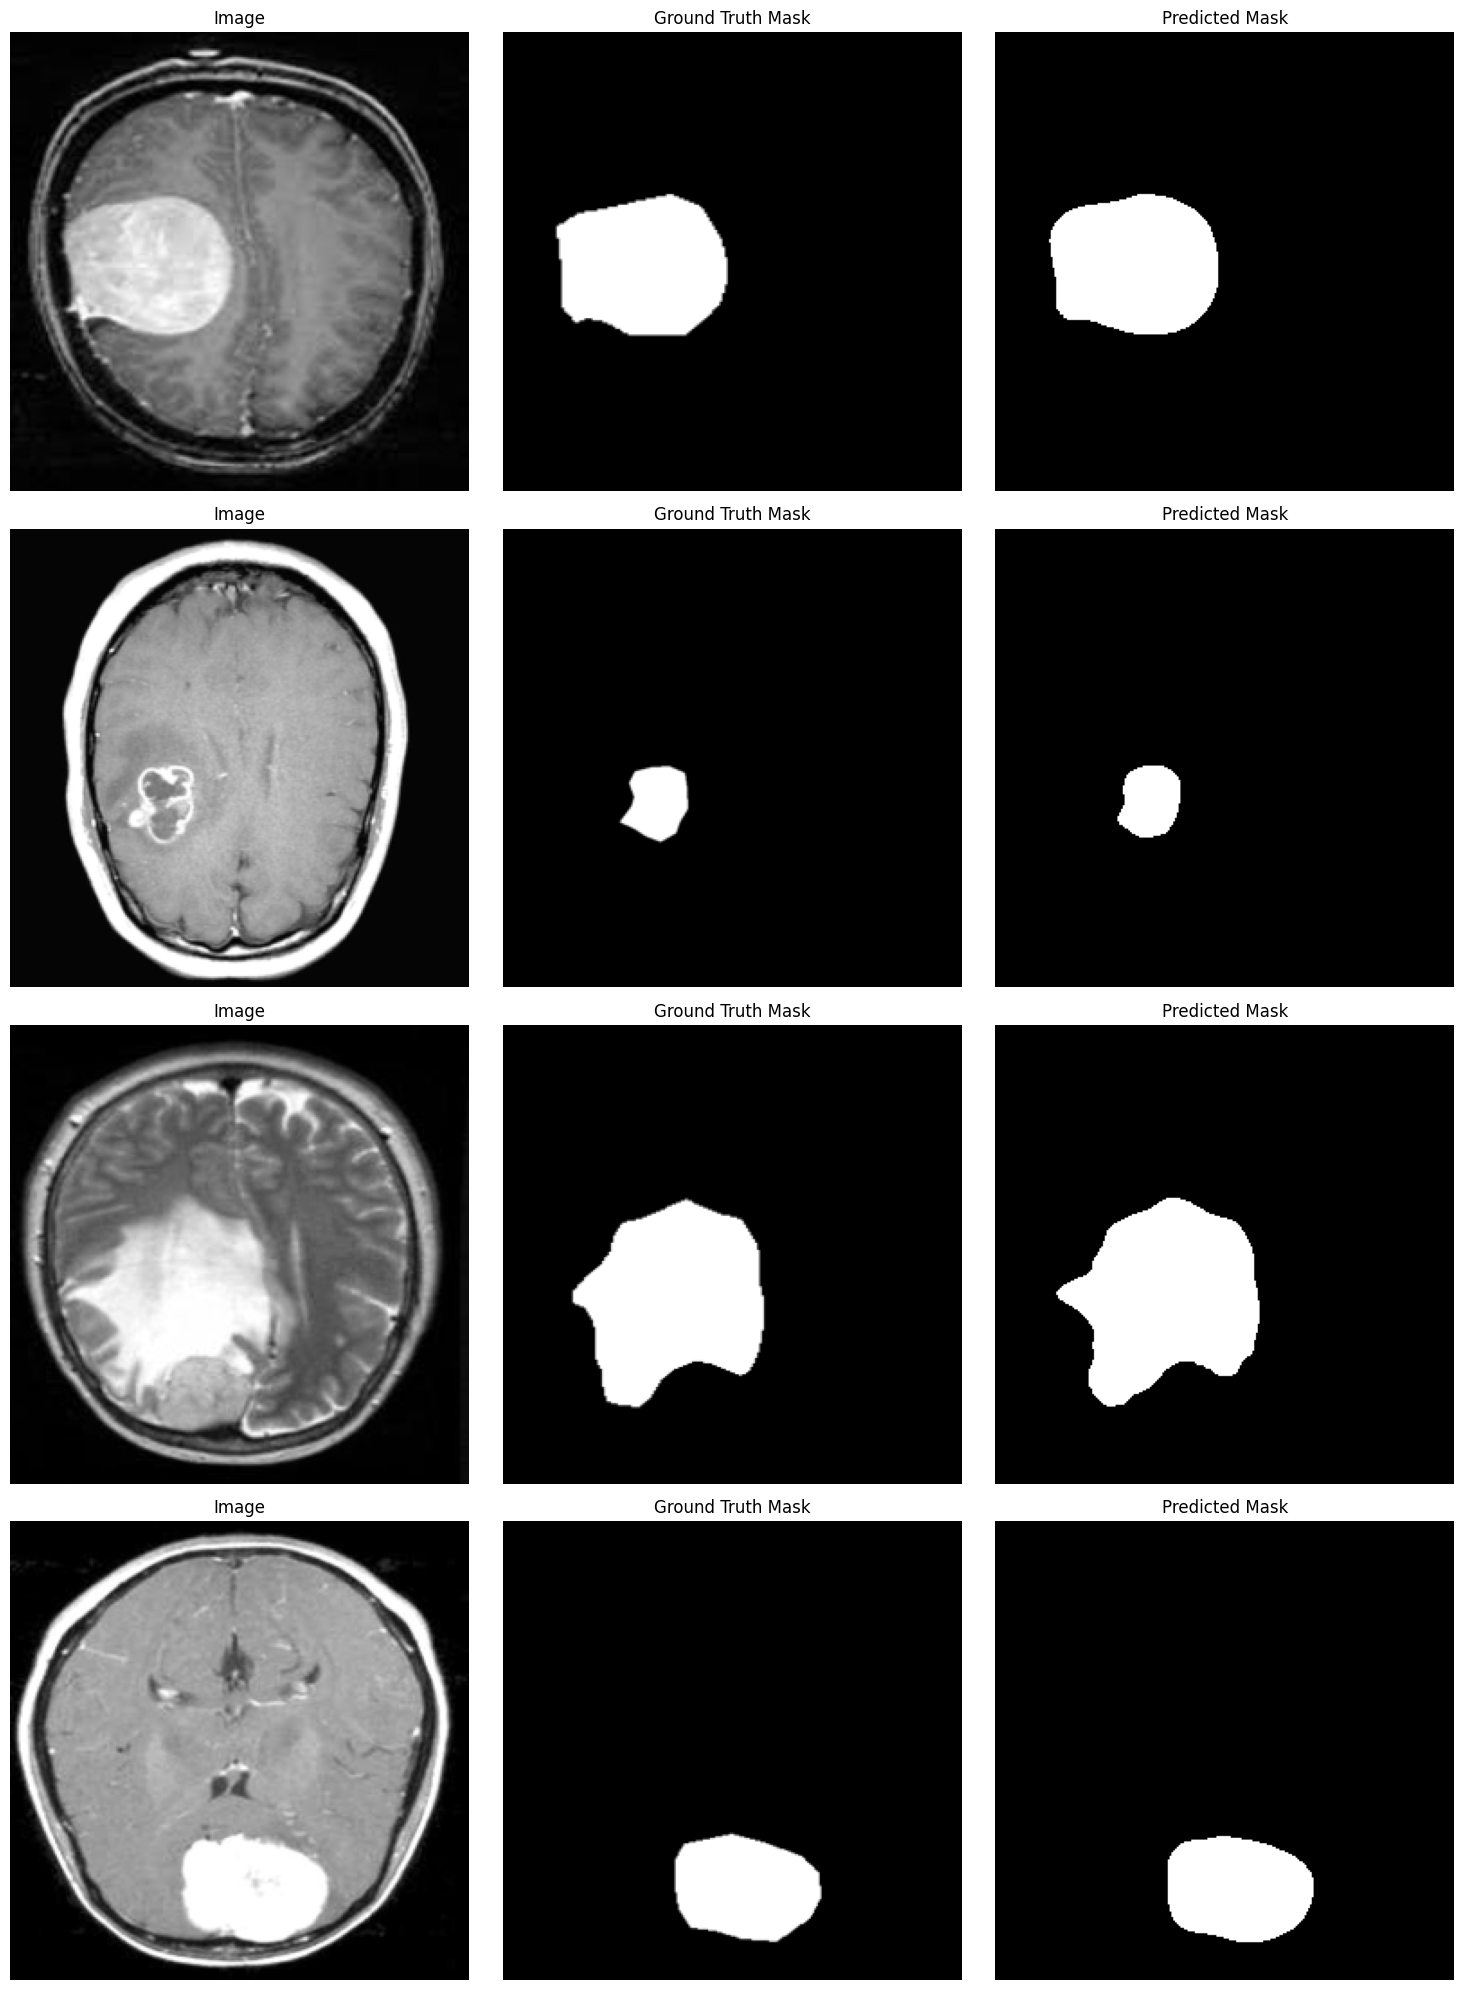

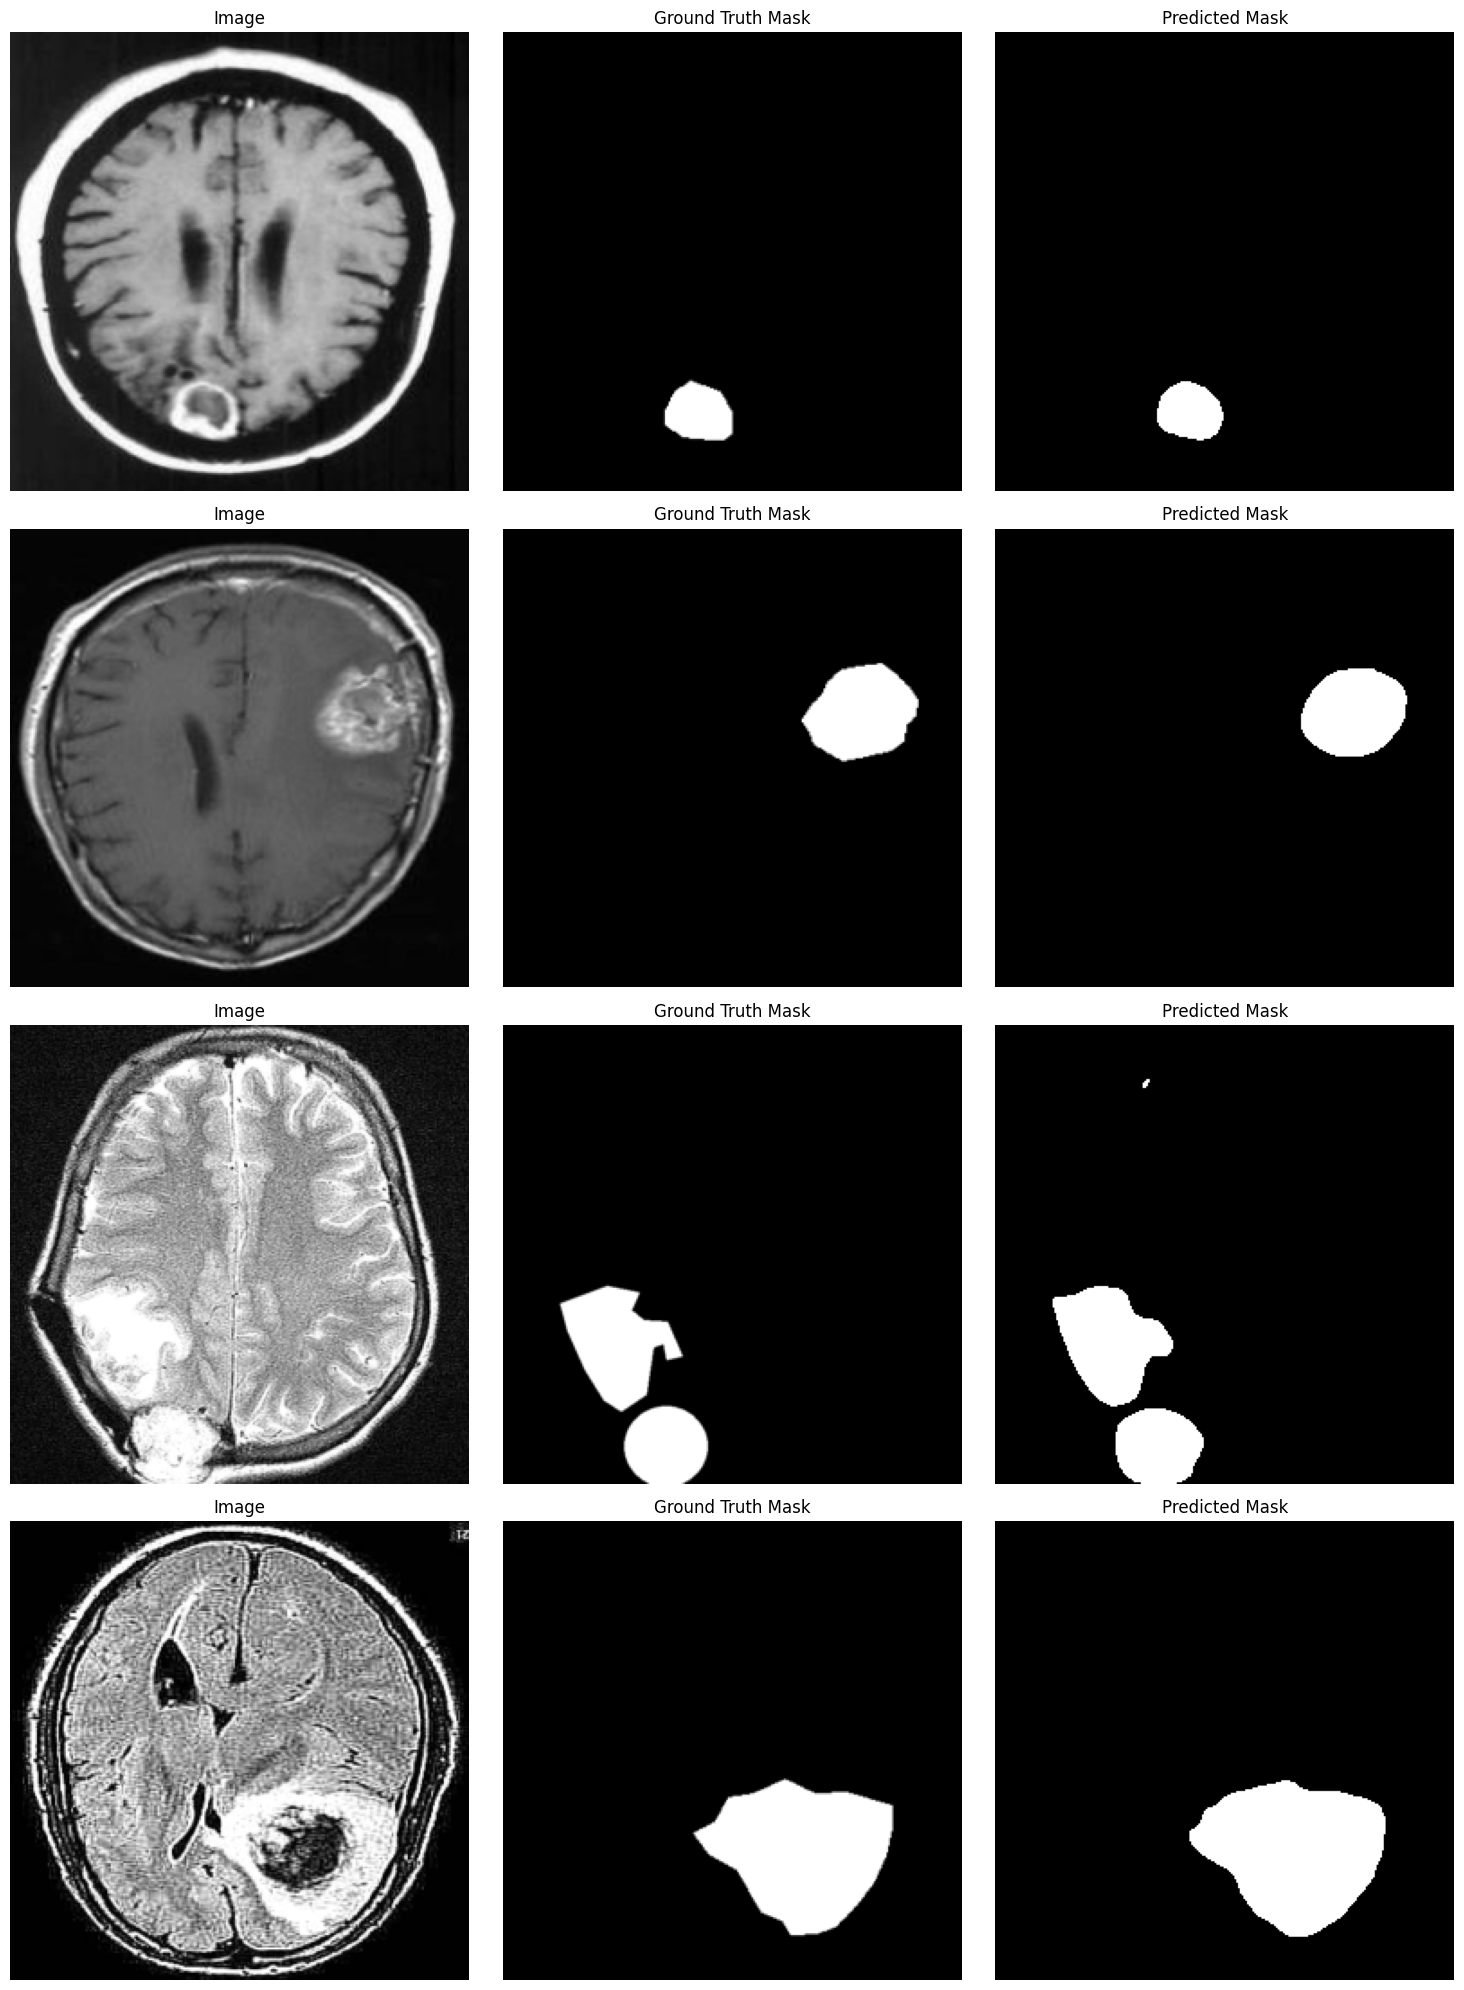

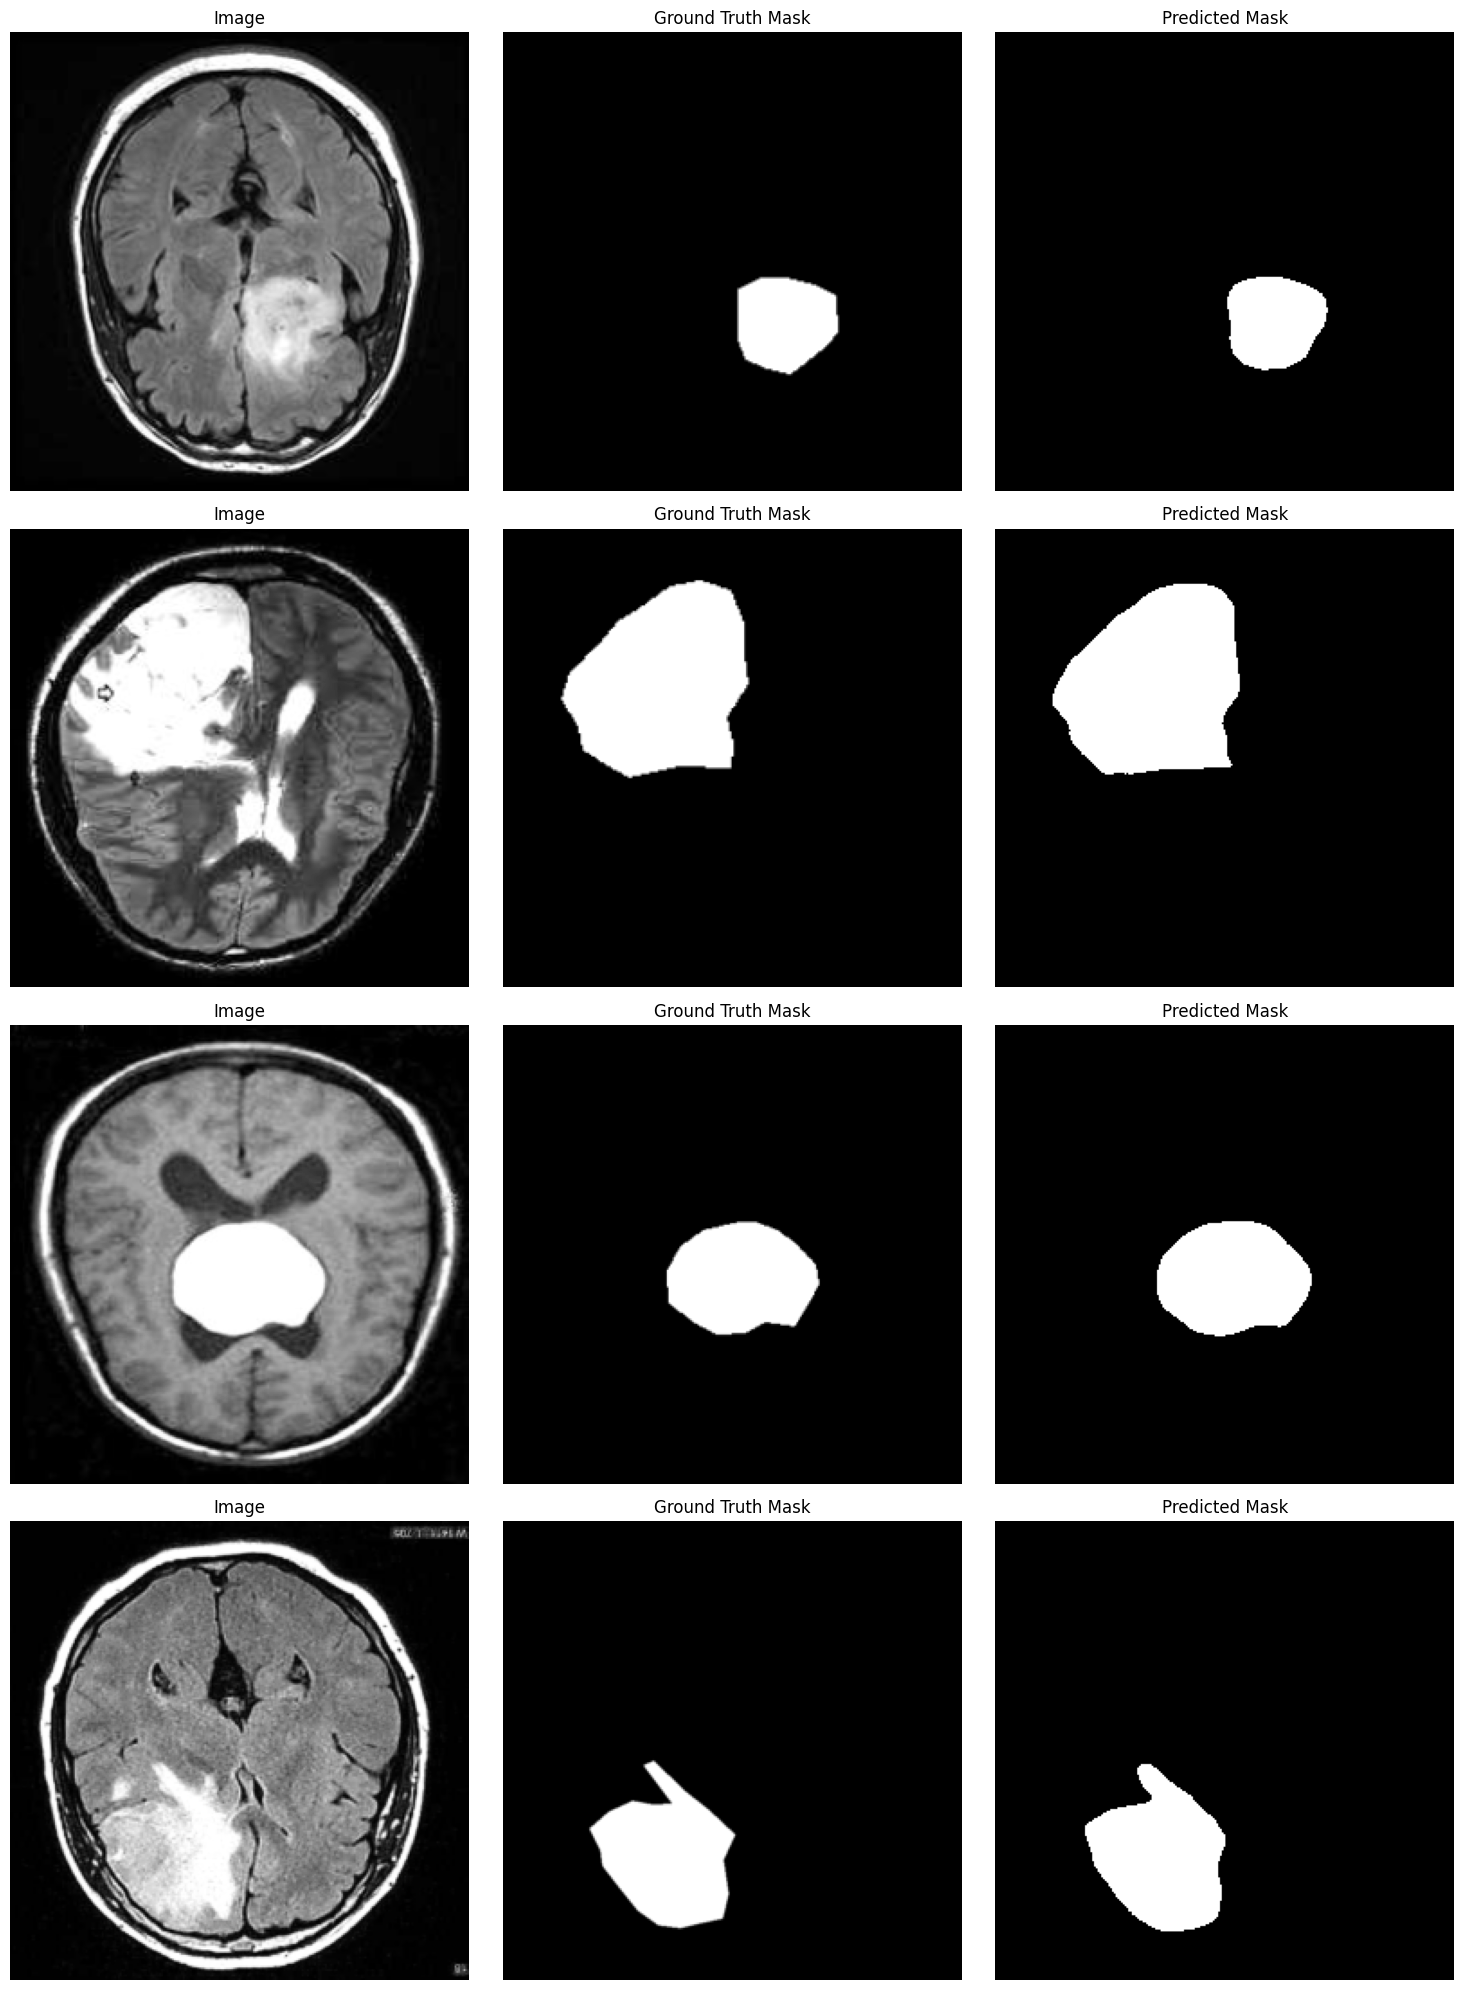

In [46]:
# Visualize some training and validation samples
num_images_to_visualize = 3

# Training samples
with torch.no_grad():
    model.eval()
    for i, (images, masks) in enumerate(train_loader):
        if i >= num_images_to_visualize:
            break
        images = images.to(device)
        masks = masks.to(device)
        predictions = model(images)
        predictions = torch.sigmoid(predictions)
        predictions = (predictions > 0.5).float()
        visualize_images_masks(images, masks, predictions)

## Validation Mask

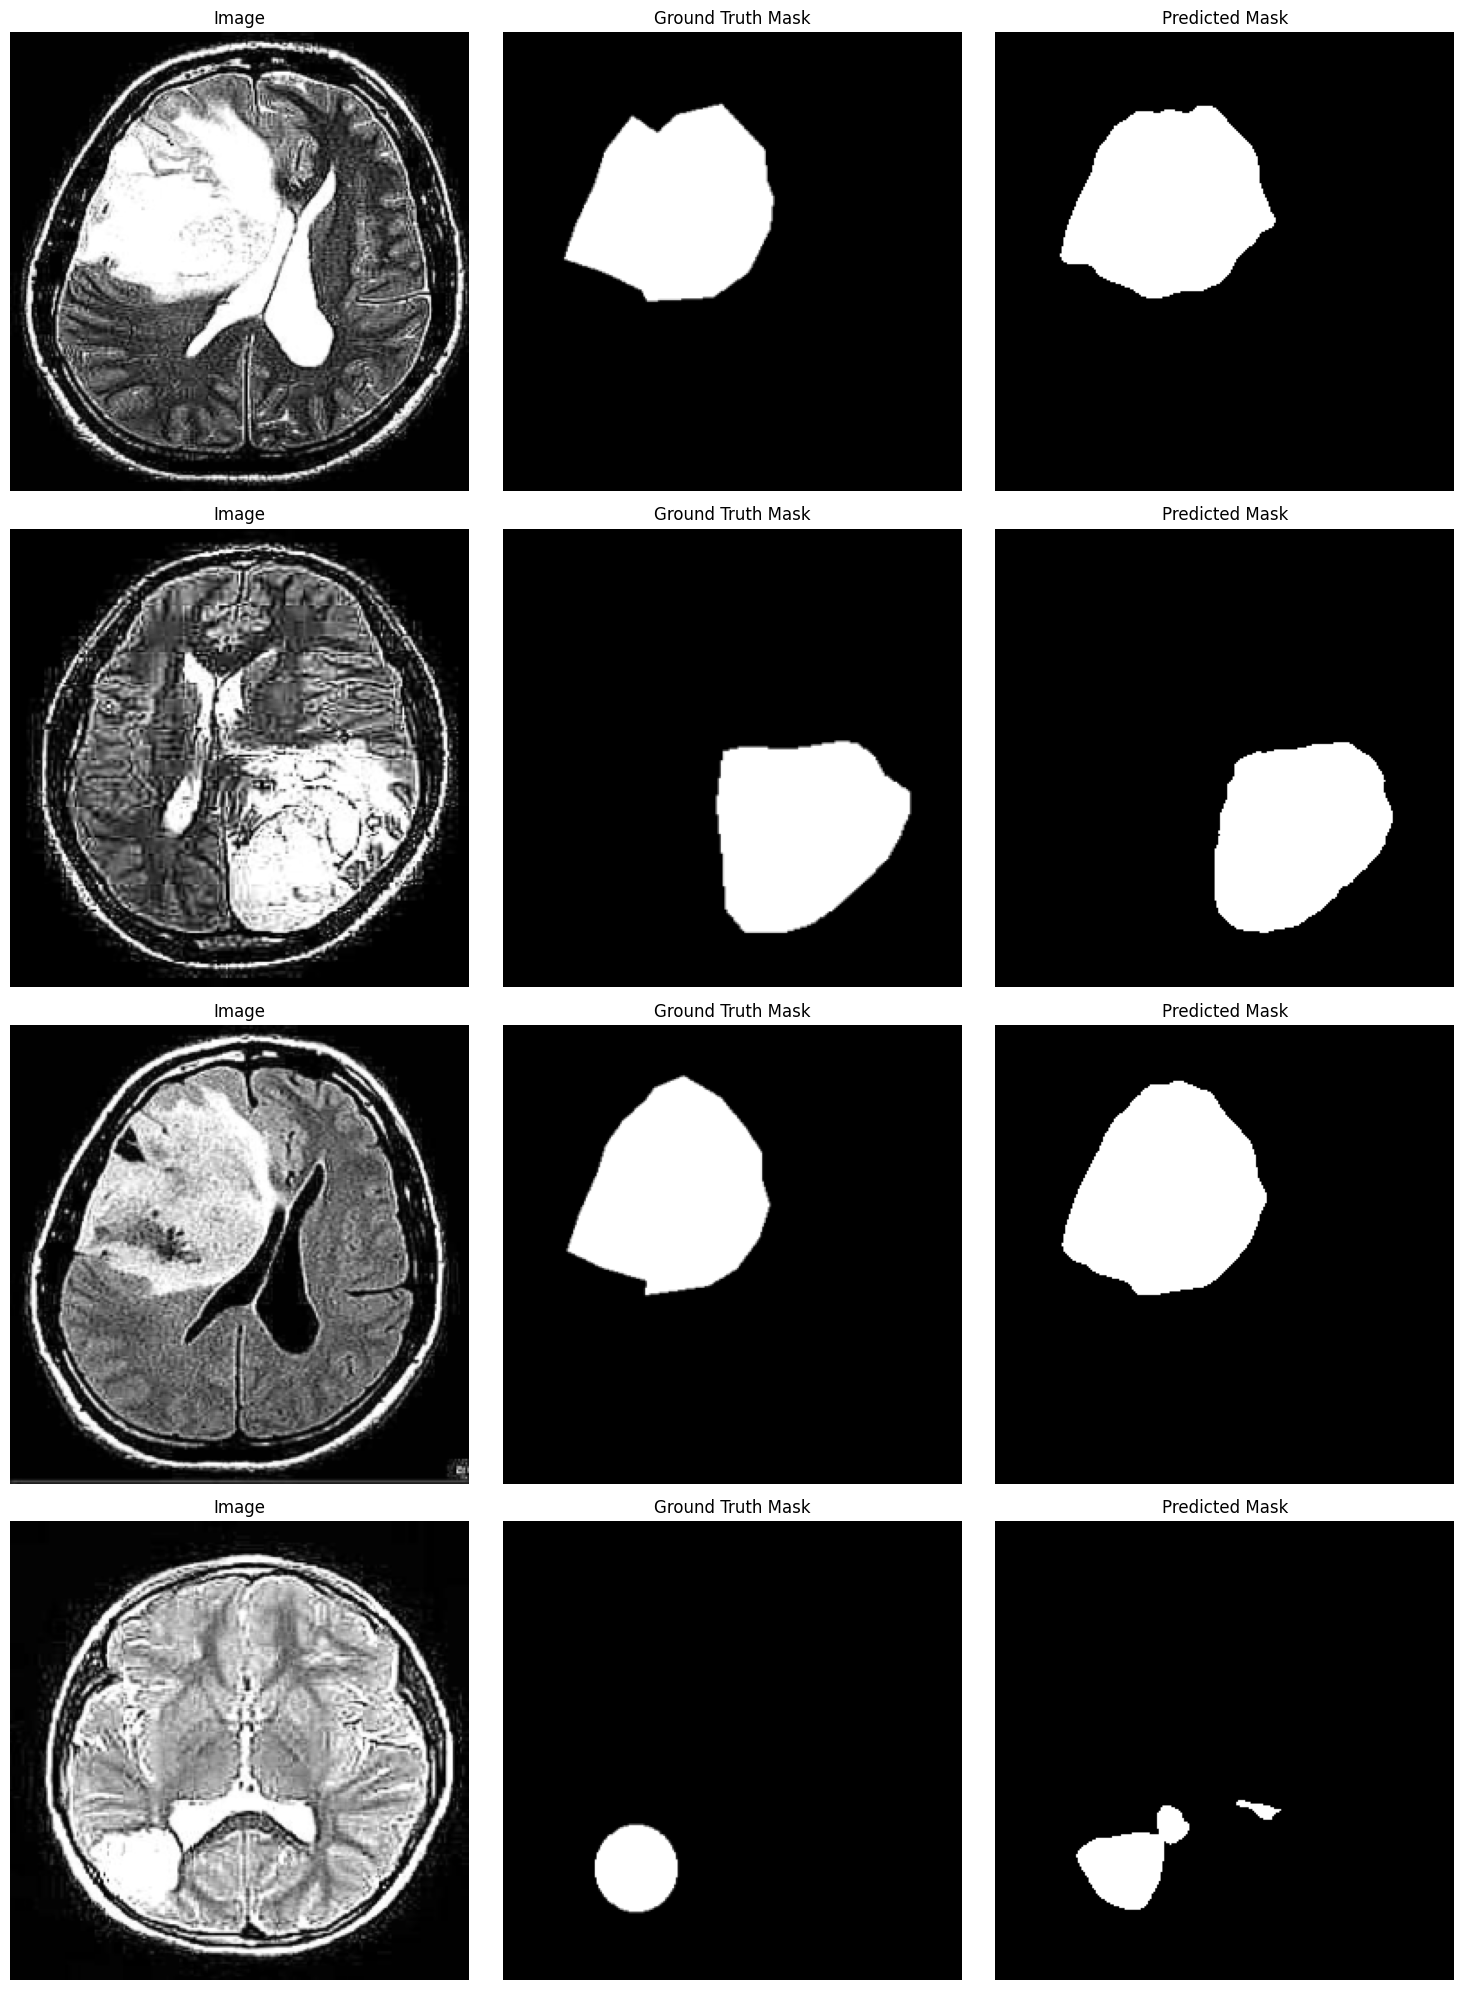

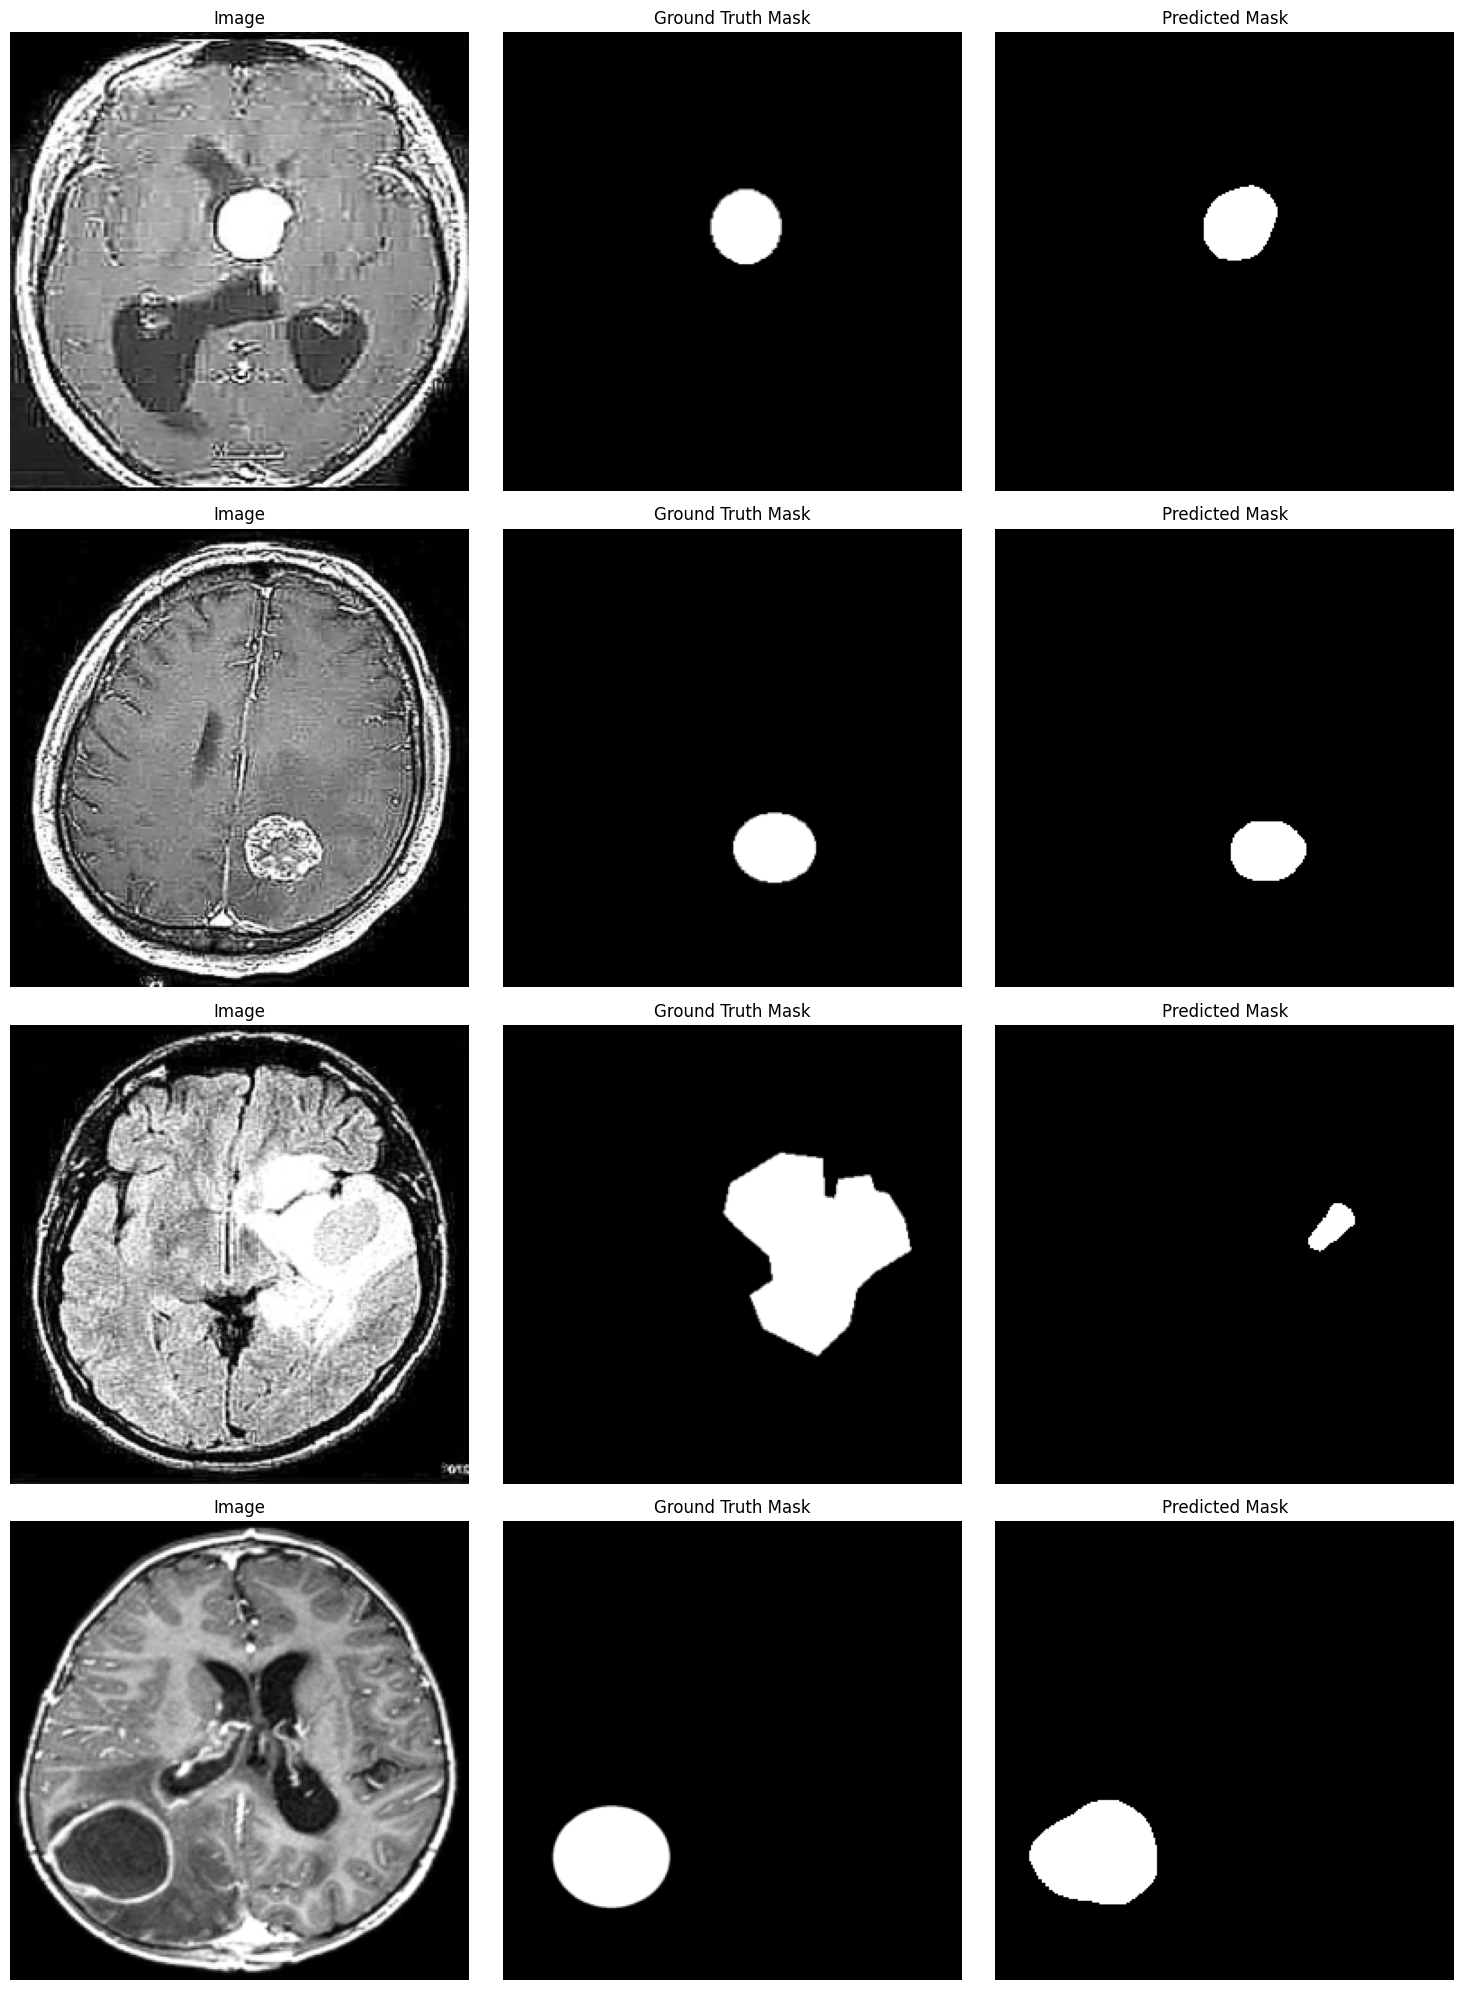

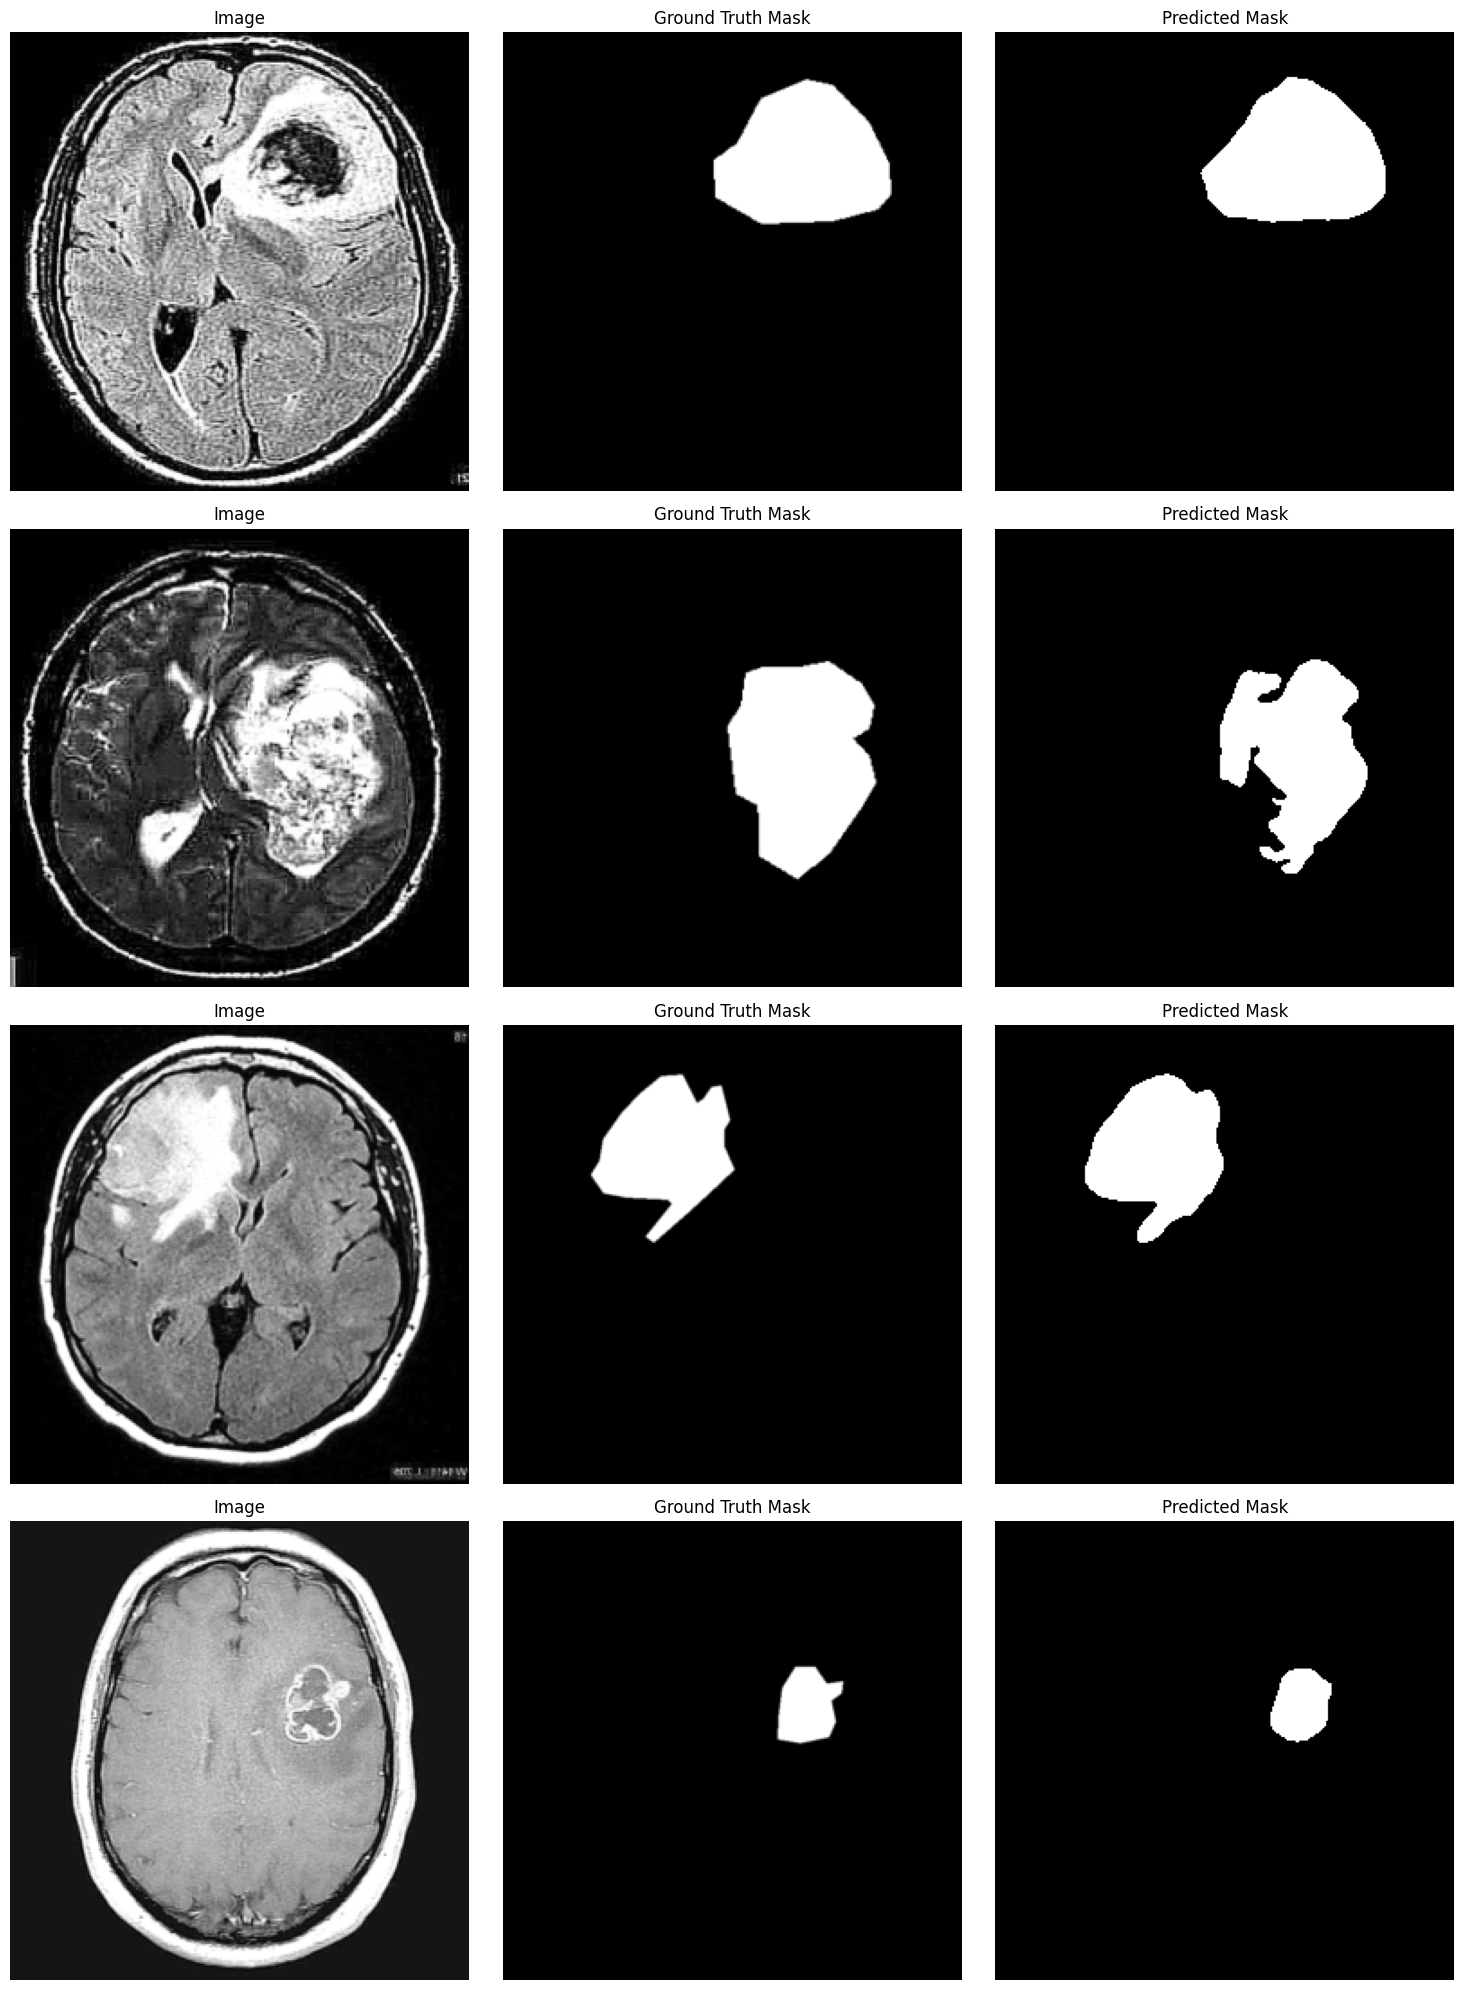

In [47]:
# Validation samples
with torch.no_grad():
    model.eval()
    for i, (images, masks) in enumerate(val_loader):
        if i >= num_images_to_visualize:
            break
        images = images.to(device)
        masks = masks.to(device)
        predictions = model(images)
        predictions = torch.sigmoid(predictions)
        predictions = (predictions > 0.5).float()
        visualize_images_masks(images, masks, predictions)

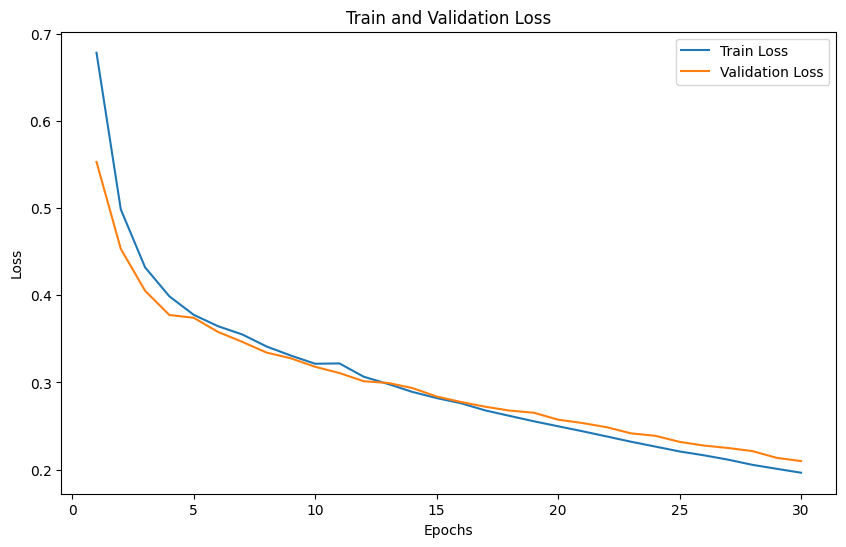

In [48]:
# Plot graphs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label='Train Loss')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

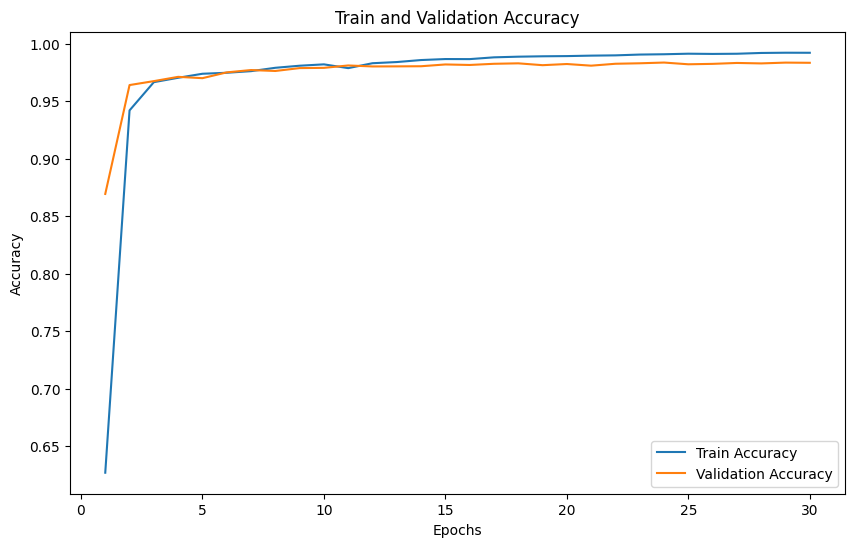

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracy_values) + 1), train_accuracy_values, label='Train Accuracy')
plt.plot(range(1, len(val_accuracy_values) + 1), val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()

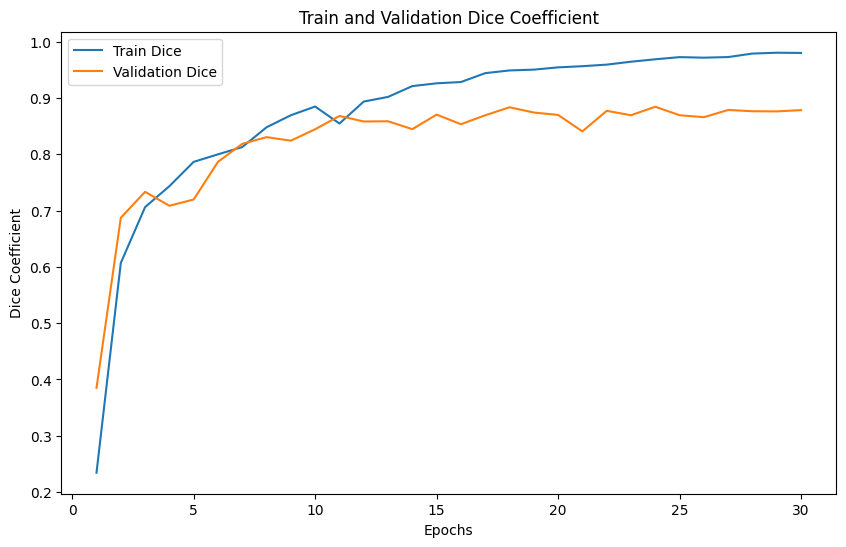

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_dice_values) + 1), train_dice_values, label='Train Dice')
plt.plot(range(1, len(val_dice_values) + 1), val_dice_values, label='Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.title('Train and Validation Dice Coefficient')
plt.show()

In [54]:
# Function to calculate metrics from the confusion matrix
def calculate_metrics(cm):
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN)  # Sensitivity (True Positive Rate)
    specificity = TN / (TN + FP)  # Specificity (True Negative Rate)
    tpr = sensitivity  # True Positive Rate (TPR) is the same as sensitivity
    fpr = FP / (FP + TN)  # False Positive Rate (FPR)

    return accuracy, sensitivity, specificity, tpr, fpr

# Calculate and print metrics for training data
train_accuracy, train_sensitivity, train_specificity, train_tpr, train_fpr = calculate_metrics(train_cm)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Sensitivity: {train_sensitivity:.4f}")
print(f"Training Specificity: {train_specificity:.4f}")
print(f"Training True Positive Rate (TPR): {train_tpr:.4f}")
print(f"Training False Positive Rate (FPR): {train_fpr:.4f}")

print('\n')


# Calculate and print metrics for validation data
val_accuracy, val_sensitivity, val_specificity, val_tpr, val_fpr = calculate_metrics(val_cm)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Sensitivity: {val_sensitivity:.4f}")
print(f"Validation Specificity: {val_specificity:.4f}")
print(f"Validation True Positive Rate (TPR): {val_tpr:.4f}")
print(f"Validation False Positive Rate (FPR): {val_fpr:.4f}")


Training Accuracy: 0.9940
Training Sensitivity: 0.9798
Training Specificity: 0.9948
Training True Positive Rate (TPR): 0.9798
Training False Positive Rate (FPR): 0.0052


Validation Accuracy: 0.9862
Validation Sensitivity: 0.8401
Validation Specificity: 0.9944
Validation True Positive Rate (TPR): 0.8401
Validation False Positive Rate (FPR): 0.0056
